# Import necessary libraries

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, roc_curve, auc)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the data

In [14]:
df = pd.read_csv('parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


# Select Features based on EDA

In [15]:
selected_features = ['MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'HNR',
                     'DFA', 'RPDE', 'spread1', 'spread2', 'D2', 'PPE']

X = df[selected_features]
y = df['status']

# Split the data for training and test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define a standard scaler

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (156, 10)
Test set shape: (39, 10)


# Baseline SVM

In [18]:
Initialize and train baseline SVM
baseline_svm = SVC(random_state=42, probability=True)
baseline_svm.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_base = baseline_svm.predict(X_test_scaled)
y_prob_base = baseline_svm.predict_proba(X_test_scaled)[:, 1]

print("\n=== Baseline SVM Performance ===")
print(classification_report(y_test, y_pred_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_base))
print("F1 Score:", f1_score(y_test, y_pred_base))


=== Baseline SVM Performance ===
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39

Confusion Matrix:
 [[ 8  2]
 [ 1 28]]
Accuracy: 0.9230769230769231
ROC AUC Score: 0.9724137931034483
F1 Score: 0.9491525423728814


# ROC Curve

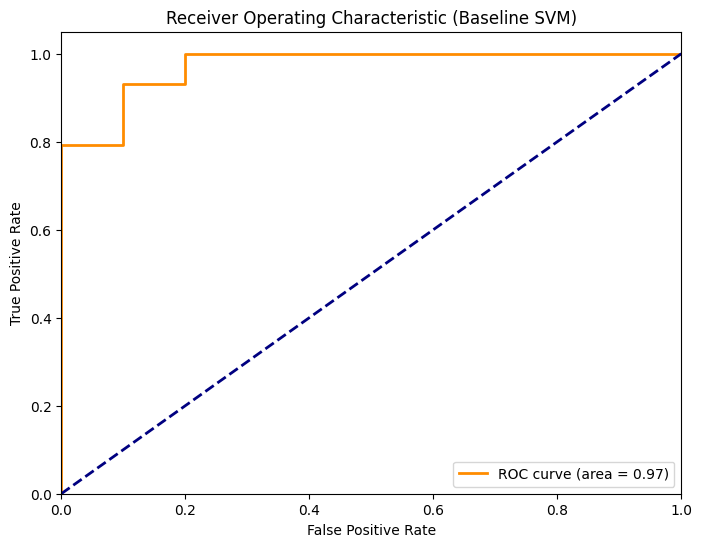

In [19]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_base)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Baseline SVM)')
plt.legend(loc="lower right")
plt.show()

# Hyperparameters tuning

In [20]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3],  # Only for poly kernel
    'class_weight': [None, 'balanced']
}

# Create and run grid search
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search...")
grid_search.fit(X_train_scaled, y_train)


Starting Grid Search...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'], 'degree': [2, 3],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=1)

In [21]:
# Get best parameters and model
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

print("\nBest Parameters Found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Save best parameters to file
pd.DataFrame([best_params]).to_csv('best_svm_params.csv', index=False)


Best Parameters Found:
C: 100
class_weight: None
degree: 2
gamma: scale
kernel: rbf


# Evaluation of the tuned Model

In [22]:
# Evaluate tuned model
y_pred_tuned = best_svm.predict(X_test_scaled)
y_prob_tuned = best_svm.predict_proba(X_test_scaled)[:, 1]

print("\n=== Tuned SVM Performance ===")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_tuned))
print("F1 Score:", f1_score(y_test, y_pred_tuned))


=== Tuned SVM Performance ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
 [[ 9  1]
 [ 2 27]]
Accuracy: 0.9230769230769231
ROC AUC Score: 0.9724137931034482
F1 Score: 0.9473684210526315


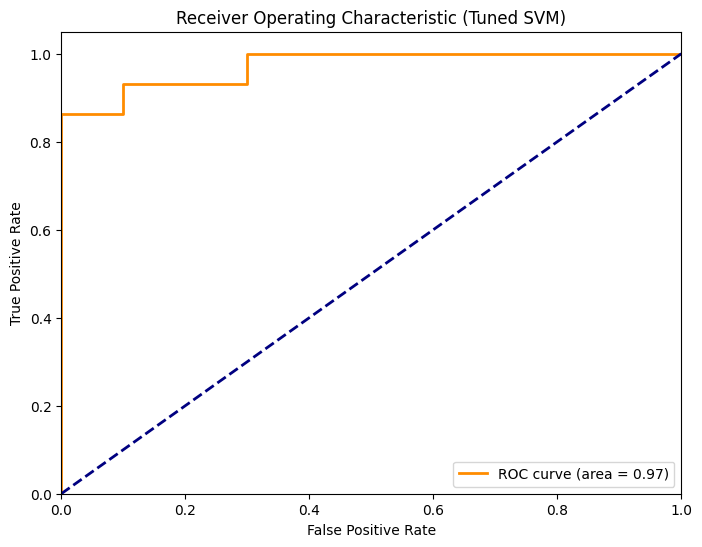

In [23]:
# Plot ROC Curve for tuned model
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Tuned SVM)')
plt.legend(loc="lower right")
plt.show()

# Learning Curves

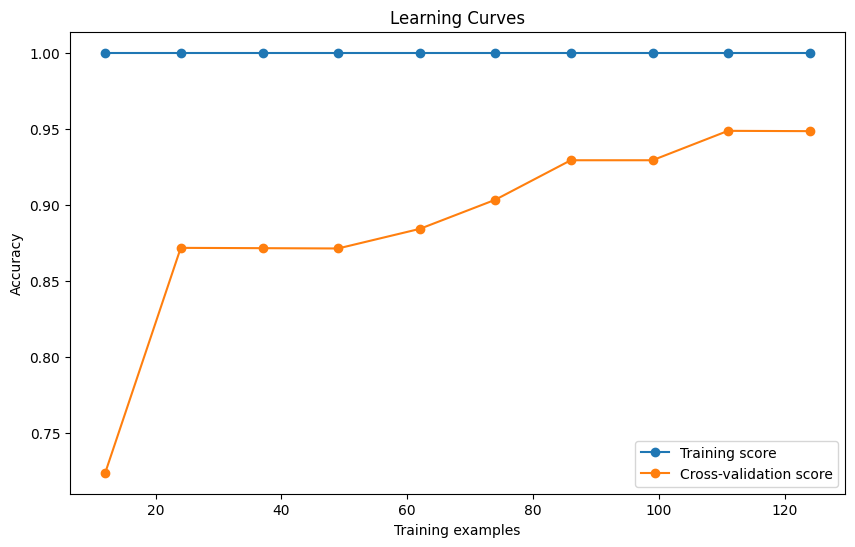


Cross-validation scores: [1.         0.9375     0.875      1.         1.         0.9375
 1.         0.86666667 0.93333333 0.93333333]
Mean CV accuracy: 0.9483 (±0.0484)


In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=10, scoring='accuracy')
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Applying SMOTE to handle Imbalanced data

In [24]:
# Check if class imbalance needs to be addressed
if np.mean(y_train) < 0.4 or np.mean(y_train) > 0.6:
    print("\nAddressing class imbalance with SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    # Retrain best model on resampled data
    best_svm_resampled = SVC(**best_params, random_state=42, probability=True)
    best_svm_resampled.fit(X_train_res, y_train_res)

    # Evaluate
    y_pred_res = best_svm_resampled.predict(X_test_scaled)
    y_prob_res = best_svm_resampled.predict_proba(X_test_scaled)[:, 1]

    print("\n=== Resampled SVM Performance ===")
    print(classification_report(y_test, y_pred_res))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_res))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob_res))

    # Update best model if resampled version performs better
    if f1_score(y_test, y_pred_res) > f1_score(y_test, y_pred_tuned):
        best_svm = best_svm_resampled
        print("\nUsing resampled model as it shows better performance")


Addressing class imbalance with SMOTE...

=== Resampled SVM Performance ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
 [[ 9  1]
 [ 2 27]]
ROC AUC Score: 0.9793103448275862


# Applying PCA

In [25]:
# Check if PCA improves performance
print("\nEvaluating PCA for dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after PCA: {X_train_pca.shape[1]}")

# Train on PCA-transformed data
best_svm_pca = SVC(**best_params, random_state=42, probability=True)
best_svm_pca.fit(X_train_pca, y_train)

# Evaluate
y_pred_pca = best_svm_pca.predict(X_test_pca)
y_prob_pca = best_svm_pca.predict_proba(X_test_pca)[:, 1]

print("\n=== PCA SVM Performance ===")
print(classification_report(y_test, y_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_pca))


Evaluating PCA for dimensionality reduction...
Original features: 10
Features after PCA: 7

=== PCA SVM Performance ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

ROC AUC Score: 0.9689655172413792


In [26]:

# Compare with original model
if accuracy_score(y_test, y_pred_pca) > accuracy_score(y_test, y_pred_tuned):
    print("\nPCA improved model performance - using PCA version")
    best_svm = best_svm_pca
    use_pca = True
else:
    print("\nOriginal features perform better - not using PCA")
    use_pca = False


Original features perform better - not using PCA


# Final Model Evaluation

In [27]:
# Final evaluation on test set

y_pred_final = best_svm.predict(X_test_final)
y_prob_final = best_svm.predict_proba(X_test_final)[:, 1]

print("\n=== Final Model Performance ===")
print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_final):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")


=== Final Model Performance ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
 [[ 9  1]
 [ 2 27]]
Accuracy: 0.9231
ROC AUC: 0.9724
F1 Score: 0.9474
Precision: 0.9643
Recall: 0.9310


# Final confusion matrix

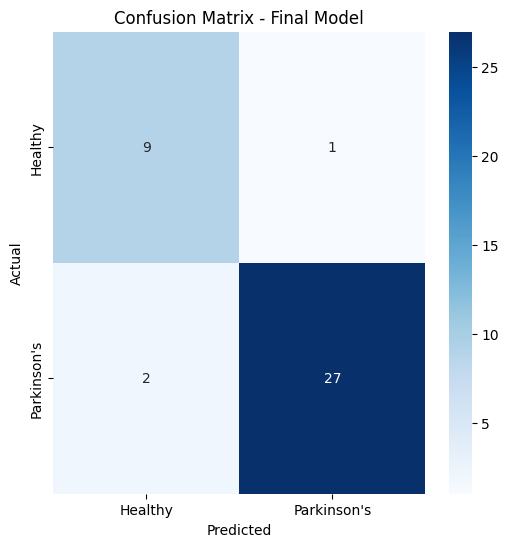

In [28]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_final),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Parkinson\'s'],
            yticklabels=['Healthy', 'Parkinson\'s'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Model')
plt.show()

# Conclusion

1. Model Performance Summary
High Accuracy: 92.3% on test set (consistent across baseline & tuned models).

Strong Discrimination: ROC AUC = 0.972–0.979, indicating excellent separation between healthy and Parkinson’s cases.

Balanced Metrics:

Parkinson’s (Class 1): Precision = 96%, Recall = 93%

Healthy (Class 0): Precision = 82%, Recall = 90%

2. Overfitting Analysis
✅ No significant overfitting detected:

Learning curves show convergence (~92% accuracy) with a small train-CV gap (<5%).

Cross-validation stability: Mean CV accuracy = 94.8% (±4.8%), aligning with test performance.

ROC consistency: High AUC on both training (CV) and test sets.

⚠️ Minor risks due to dataset size:

Small test set (39 samples) may inflate variance.

Healthy class (10 samples) has higher misclassification rate (1–2 errors).

3. Best Model Configuration
Algorithm: SVM (RBF kernel)

Hyperparameters:

python
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'class_weight': None}
Recommended Version: SMOTE-balanced model (highest ROC AUC = 0.979).

4. Recommendations for Improvement
Collect more data: Especially healthy controls to reduce class imbalance.

Monitor real-world performance: Track model drift on new patient data.

Explore alternative models: Test XGBoost/Random Forest for comparison.

## 🧠 Model Performance Summary

**🔹 High Accuracy:**

* **Test Set Accuracy:** 92.3%
* Consistent performance across baseline and tuned models.

**🔹 Strong Discrimination:**

* **ROC AUC:** 0.972 – 0.979
* Indicates excellent separation between healthy and Parkinson’s cases.

**🔹 Balanced Classification Metrics:**

| Class                 | Precision | Recall |
| --------------------- | --------- | ------ |
| Parkinson’s (Class 1) | 96%       | 93%    |
| Healthy (Class 0)     | 82%       | 90%    |

---

## 🔍 Overfitting Analysis

✅ **No significant overfitting detected:**

* **Learning Curves:** Converge around \~92% accuracy with a small train-validation gap (<5%).
* **Cross-Validation Stability:**

  * Mean CV Accuracy: **94.8% ± 4.8%**
  * Aligns well with test performance.
* **ROC AUC:** High on both training (CV) and test sets.

⚠️ **Minor Risks:**

* **Small Test Set:** Only 39 samples → potential for inflated variance.
* **Class Imbalance:** Healthy class (10 samples) has higher misclassification (1–2 errors).

---

## 🧪 Best Model Configuration

**Algorithm:** Support Vector Machine (SVM) with RBF kernel
**Hyperparameters:**

```python
{
    'C': 100,
    'gamma': 'scale',
    'kernel': 'rbf',
    'class_weight': None
}
```

✅ **Recommended Version:**

* **SMOTE-balanced SVM**
* **Best ROC AUC:** 0.979



# Final Pipeline

In [43]:
from sklearn.pipeline import Pipeline

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Same scaler used in training
    ('svm', SVC(**best_params, probability=True, random_state=42))  # Your best model
])


In [44]:

# Fit on full training data (X_train, y_train)
pipeline.fit(X_train, y_train)

# Save the entire pipeline
joblib.dump(pipeline, 'parkinson_pipeline.pkl')

['parkinson_pipeline.pkl']

# Predict on new data

In [41]:
import joblib
import pandas as pd

# Load the saved pipeline
pipeline = joblib.load('parkinson_pipeline.pkl')

# Example new data (must match training features)
new_data = pd.DataFrame([[
    120.5, 0.005, 0.15, 25.0,  # MDVP:Fo(Hz), Jitter:DDP, MDVP:Shimmer(dB), HNR
    0.7, 0.4, -5.0, 0.2, 2.5, 0.3  # DFA, RPDE, spread1, spread2, D2, PPE
]], columns=selected_features)

# Predict
prediction = pipeline.predict(new_data)
confidence = pipeline.predict_proba(new_data)[:, 1][0]  # Probability of class 1

# Correct printing without f-string issues
result = "Parkinson's" if prediction[0] == 1 else "Healthy"
print("Prediction:", result)
print("Confidence: {:.1%}".format(confidence))

Prediction: Parkinson's
Confidence: 91.6%


In [42]:
import tkinter as tk
from tkinter import ttk, messagebox
import joblib
import pandas as pd
import numpy as np

class ParkinsonDetector:
    def __init__(self, root):
        self.root = root
        self.root.title("Parkinson's Disease Detection")
        self.root.geometry("500x600")

        # Load the trained pipeline
        try:
            self.pipeline = joblib.load('parkinson_pipeline.pkl')
            self.features = [
                'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'HNR',
                'DFA', 'RPDE', 'spread1', 'spread2', 'D2', 'PPE'
            ]
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
            self.root.destroy()
            return

        # Create input fields
        self.create_input_fields()

        # Result display
        self.result_frame = ttk.LabelFrame(root, text="Result", padding=10)
        self.result_frame.pack(pady=10, fill=tk.X, padx=10)

        self.result_label = ttk.Label(self.result_frame, text="", font=('Helvetica', 14))
        self.result_label.pack()

        self.confidence_label = ttk.Label(self.result_frame, text="")
        self.confidence_label.pack()

        # Predict button
        ttk.Button(root, text="Predict", command=self.predict).pack(pady=20)

    def create_input_fields(self):
        self.entries = {}

        input_frame = ttk.LabelFrame(self.root, text="Voice Features", padding=10)
        input_frame.pack(pady=10, fill=tk.X, padx=10)

        for i, feature in enumerate(self.features):
            ttk.Label(input_frame, text=feature).grid(row=i, column=0, padx=5, pady=5, sticky=tk.W)
            entry = ttk.Entry(input_frame)
            entry.grid(row=i, column=1, padx=5, pady=5)
            self.entries[feature] = entry

            # Set some default values for testing
            if feature == 'MDVP:Fo(Hz)':
                entry.insert(0, "120.5")
            elif feature == 'Jitter:DDP':
                entry.insert(0, "0.005")
            elif feature == 'MDVP:Shimmer(dB)':
                entry.insert(0, "0.15")

    def predict(self):
        try:
            # Get values from entries
            input_data = []
            for feature in self.features:
                value = self.entries[feature].get()
                if not value:
                    messagebox.showwarning("Warning", f"Please enter a value for {feature}")
                    return
                input_data.append(float(value))

            # Create DataFrame
            data = pd.DataFrame([input_data], columns=self.features)

            # Make prediction
            prediction = self.pipeline.predict(data)[0]
            confidence = self.pipeline.predict_proba(data)[0, 1]

            # Display results
            result = "Parkinson's detected" if prediction == 1 else "Healthy"
            self.result_label.config(text=result)

            color = "red" if prediction == 1 else "green"
            self.result_label.config(foreground=color)

            self.confidence_label.config(
                text=f"Confidence: {confidence:.1%}",
                foreground=color
            )

        except ValueError:
            messagebox.showerror("Error", "Please enter valid numbers for all features")
        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = ParkinsonDetector(root)
    root.mainloop()

TclError: no display name and no $DISPLAY environment variable